# Deep Convolutional Generative Adversarial Networks

we introduced the basic ideas behind how GANs work. We showed that they can draw samples from some simple, easy-to-sample distribution, like a uniform or normal distribution, and transform them into samples that appear to match the distribution of some dataset. And while our example of matching a 2D Gaussian distribution got the point across, it is not especially exciting.

In this section, we will demonstrate how you can use GANs to generate photorealistic images. We will be basing our models on the deep convolutional GANs (DCGAN) introduced in :cite:`Radford.Metz.Chintala.2015`. We will borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how via GANs, they can be leveraged to generate photorealistic images.

In [77]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from torch.autograd import Variable
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import zipfile
cuda = True if torch.cuda.is_available() else False
print(cuda)

False


## The Pokemon Dataset

The dataset we will use is a collection of Pokemon sprites obtained from [pokemondb](https://pokemondb.net/sprites). First download, extract and load this dataset.

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.

In [78]:
data_dir='/home/xixixi/桌面/Dive-into-DL-PyTorch/data/pokemon-images-and-types/images'
batch_size=256
transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
pokemon=ImageFolder(data_dir,transform)
data_iter=DataLoader(pokemon,batch_size=batch_size,shuffle=True)

Let's visualize the first 20 images.

(120, 120, 4)


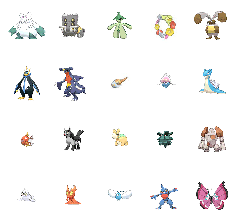

In [79]:
fig=plt.figure(figsize=(4,4))
imgs=data_iter.dataset.imgs
b = plt.imread(imgs[40][0])#看个数据大小玩玩
print(b.shape)
for i in range(20):
    img = plt.imread(imgs[i*40][0])
    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . In :numref:`sec_fcn` we introduced the fully convolutional network that uses transposed convolution layer（转置卷积层对噪声进行放大到图片大小） (refer to :numref:`sec_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.

In [80]:
class G_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4,strides=2, padding=1):
        super(G_block,self).__init__()
        self.conv2d_trans=nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                                             stride=strides, padding=padding, bias=False)
        self.batch_norm=nn.BatchNorm2d(out_channels,0.8)
        self.activation=nn.ReLU()
    def forward(self,x):
        return self.activation(self.batch_norm(self.conv2d_trans(x)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.


$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [81]:
Tensor=torch.FloatTensor
x=Variable(Tensor(np.zeros((2,3,16,16))))
g_blk=G_block(3,20)
#g_blk.cuda()
print(g_blk(x).shape)

torch.Size([2, 20, 32, 32])


If changing the transposed convolution layer to a $4\times 4$ kernel, $1\times 1$ strides and zero padding. With a input size of $1 \times 1$, the output will have its width and height increased by 3 respectively.

In [83]:
x=Variable(Tensor(np.zeros((2,3,1,1))))
g_blk=G_block(3,20,strides=1,padding=0)
#g_blk.cuda()
print(g_blk(x).shape)

torch.Size([2, 20, 4, 4])


The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [84]:
class net_G(nn.Module):
    def __init__(self,in_channels):
        super(net_G,self).__init__()

        n_G=64
        self.model=nn.Sequential(
            G_block(in_channels,n_G*8,strides=1,padding=0),
            G_block(n_G*8,n_G*4),
            G_block(n_G*4,n_G*2),
            G_block(n_G*2,n_G),
            nn.ConvTranspose2d(
                n_G,3,kernel_size=4,stride=2,padding=1,bias=False
            ),#转置卷积层enlarge
            nn.Tanh() #激活函数
        )
    def forward(self,x):
        x=self.model(x)
        return x


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, mean=0, std=0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Generate a 100 dimensional latent variable to verify the generator's output shape.

In [85]:
x=Variable(Tensor(np.zeros((1,100,1,1))))
generator=net_G(100)
#generator.cuda()
generator.apply(weights_init_normal)
print(generator(x).shape)

torch.Size([1, 3, 64, 64])


## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is


$$
\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.
$$


As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

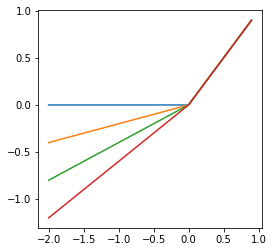

In [86]:
alphas = [0, 0.2, 0.4, .6]
x = np.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(Tensor(x)).cpu().numpy()for alpha in alphas]
plt.figure(figsize=(4,4))
for y in Y:
    plt.plot(x,y)
plt.show()

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyper-parameters of the convolution layer are similar to the transpose convolution layer in the generator block.

In [87]:
class D_block(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=4,strides=2,
                 padding=1,alpha=0.2):
        super(D_block,self).__init__()
        self.conv2d=nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding,bias=False)
        self.batch_norm=nn.BatchNorm2d(out_channels,0.8)
        self.activation=nn.LeakyReLU(alpha)
    def forward(self,X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block with default settings will halve the width and height of the inputs, as we demonstrated in :numref:`sec_padding`. For example, given a input shape $n_h = n_w = 16 $, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:


$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [88]:
x = Variable(Tensor(np.zeros((2, 3, 16, 16))))
d_blk = D_block(3,20)
#d_blk.cuda()
print(d_blk(x).shape)

torch.Size([2, 20, 8, 8])


The discriminator is a mirror of the generator.

In [89]:
class net_D(nn.Module):
    def __init__(self,in_channels):
        super(net_D,self).__init__()
        n_D=64
        self.model=nn.Sequential(
            D_block(in_channels,n_D),
            D_block(n_D,n_D*2),
            D_block(n_D*2,n_D*4),
            D_block(n_D*4,n_D*8)
        )
        self.conv=nn.Conv2d(n_D*8,1,kernel_size=4,bias=False)
        self.activation=nn.Sigmoid()
        # self._initialize_weights()
    def forward(self,x):
        x=self.model(x)
        x=self.conv(x)
        x=self.activation(x)
        return x

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.

In [90]:
x = Variable(Tensor(np.zeros((1, 3, 64, 64))))
discriminator=net_D(3)
#discriminator.cuda()
discriminator.apply(weights_init_normal)
print(discriminator(x).shape)

torch.Size([1, 1, 1, 1])


## Training
Compared to the basic GAN in :numref:`sec_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`sec_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, the random generated noise `Z`, is a 4-D tensor and we are using GPU to accelerate the computation.

In [95]:
def update_D(X,Z,net_D,net_G,loss,trainer_D):
    batch_size=X.shape[0]
    Tensor=torch.FloatTensor
    ones=Variable(Tensor(np.ones(batch_size,)),requires_grad=False).view(batch_size,1)
    zeros = Variable(Tensor(np.zeros(batch_size,)),requires_grad=False).view(batch_size,1)
    real_Y=net_D(X).view(batch_size,-1)
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X).view(batch_size,-1)
    loss_D=(loss(real_Y,ones)+loss(fake_Y,zeros))/2
    loss_D.backward()
    trainer_D.step()
    return float(loss_D.sum())

def update_G(Z,net_D,net_G,loss,trainer_G):
    batch_size=Z.shape[0]
    Tensor=torch.FloatTensor
    ones=Variable(Tensor(np.ones((batch_size,))),requires_grad=False).view(batch_size,1)
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X).view(batch_size,-1)
    loss_G=loss(fake_Y,ones)
    loss_G.backward()
    trainer_G.step()
    return float(loss_G.sum())


def train(net_D,net_G,data_iter,num_epochs,lr,latent_dim):
    loss=nn.BCELoss() #交叉商损失
    Tensor=torch.FloatTensor
    trainer_D=torch.optim.Adam(net_D.parameters(),lr=lr,betas=(0.5,0.999))
    trainer_G=torch.optim.Adam(net_G.parameters(),lr=lr,betas=(0.5,0.999))
    plt.figure(figsize=(7,4))
    d_loss_point=[]
    g_loss_point=[]
    d_loss=0
    g_loss=0
    for epoch in range(1,num_epochs+1):
        d_loss_sum=0
        g_loss_sum=0
        batch=0
        for X in data_iter:
            X=X[:][0]
            batch+=1
            X=Variable(X.type(Tensor))
            batch_size=X.shape[0]
            Z=Variable(Tensor(np.random.normal(0,1,(batch_size,latent_dim,1,1))))

            trainer_D.zero_grad()
            d_loss = update_D(X, Z, net_D, net_G, loss, trainer_D)
            d_loss_sum+=d_loss
            trainer_G.zero_grad()
            g_loss = update_G(Z, net_D, net_G, loss, trainer_G)
            g_loss_sum+=g_loss

        d_loss_point.append(d_loss_sum/batch)
        g_loss_point.append(g_loss_sum/batch)
        print(
            "[Epoch %d/%d]  [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs,  d_loss_sum/batch_size,  g_loss_sum/batch_size)
        )


    plt.ylabel('Loss', fontdict={ 'size': 14})
    plt.xlabel('epoch', fontdict={ 'size': 14})
    plt.xticks(range(0,num_epochs+1,3))
    plt.plot(range(1,num_epochs+1),d_loss_point,color='orange',label='discriminator')
    plt.plot(range(1,num_epochs+1),g_loss_point,color='blue',label='generator')
    plt.legend()
    plt.show()
    print(d_loss,g_loss)

    Z = Variable(Tensor(np.random.normal(0, 1, size=(21, latent_dim, 1, 1))),requires_grad=False)
    fake_x = generator(Z)
    fake_x=fake_x.cpu().detach().numpy()
    plt.figure(figsize=(14,6))
    for i in range(21):
        im=np.transpose(fake_x[i])
        plt.subplot(3,7,i+1)
        plt.imshow(im)
    plt.show()

Now let's train the model.

In [ ]:
if __name__ == '__main__':
    lr,latent_dim,num_epochs=0.005,100,50
    train(discriminator,generator,data_iter,num_epochs,lr,latent_dim)

[Epoch 1/50]  [D loss: 0.081560] [G loss: 0.609892]
[Epoch 2/50]  [D loss: 0.518343] [G loss: 0.730077]
[Epoch 3/50]  [D loss: 0.429922] [G loss: 1.691703]
[Epoch 4/50]  [D loss: 0.345148] [G loss: 1.019340]
[Epoch 5/50]  [D loss: 0.446640] [G loss: 1.855151]
[Epoch 6/50]  [D loss: 0.344342] [G loss: 1.157407]
[Epoch 7/50]  [D loss: 0.388809] [G loss: 0.818480]
[Epoch 8/50]  [D loss: 0.255178] [G loss: 0.748990]
[Epoch 9/50]  [D loss: 0.280601] [G loss: 0.721993]
[Epoch 10/50]  [D loss: 0.349081] [G loss: 0.916815]
[Epoch 11/50]  [D loss: 0.359137] [G loss: 0.944219]
[Epoch 12/50]  [D loss: 0.426732] [G loss: 0.754657]
[Epoch 13/50]  [D loss: 0.420137] [G loss: 0.791857]
[Epoch 14/50]  [D loss: 0.451324] [G loss: 0.764550]
[Epoch 15/50]  [D loss: 0.402160] [G loss: 0.962707]
[Epoch 16/50]  [D loss: 0.481900] [G loss: 0.590237]
[Epoch 17/50]  [D loss: 0.303805] [G loss: 0.637268]
[Epoch 18/50]  [D loss: 0.368726] [G loss: 0.546816]
[Epoch 19/50]  [D loss: 0.357323] [G loss: 0.562827]
[E

## Summary

* DCGAN architecture has four convolutional layers for the Discriminator and four "fractionally-strided" convolutional layers for the Generator.
* The Discriminator is a 4-layer strided convolutions with batch normalization (except its input layer) and leaky ReLU activations. 
* Leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the “dying ReLU” problem and helps the gradients flow easier through the architecture.


## Exercises

* What will happen if we use standard ReLU activation rather than leaky ReLU?
* Apply DCGAN on Fashion-MNIST and see which category works well and which does not.
